In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('datasets/fundamentals.csv')

In [3]:
dflc = df[:100]

In [4]:
dflc

,Ticker,Volume,Market Capitalization,Price to Earnings Ratio (TTM),Basic EPS (TTM),Sector,Last,1-Year Beta,Basic EPS (FY),EBITDA (TTM),Goodwill,Industry,Last Year Revenue (FY),Net Debt (MRQ),Net Income (FY),Net Margin (TTM),Quick Ratio (MRQ),Return on Assets (TTM),Return on Equity (TTM),Return on Invested Capital (TTM),Revenue per Employee (TTM),Total Debt (MRQ),Total Revenue (FY),YTD Performance,Yearly Performance,Number of Employees,Gross Margin (TTM),Gross Profit (FY),Gross Profit (MRQ),Monthly Performance,Total Assets (MRQ),Total Current Assets (MRQ),Total Shares Outstanding (MRQ)
0,RELIANCE,16887752,1.211680e+13,30.146578,63.4135,Energy Minerals,1919.90000,0.799779,62.8948,8.763500e+11,1.025900e+11,Oil Refining/Marketing,5.958870e+12,2.411560e+12,3.935400e+11,6.617666,0.446476,3.629905,9.365061,6.281083,3.046177e+07,3.449910e+12,5.958870e+12,28.012360,51.555784,195618.0,25.755489,1.277320e+12,3.661600e+11,9.122428,1.165915e+13,2.582600e+12,6.339400e+09
1,TCS,2952719,8.260300e+12,26.453739,83.1924,Technology Services,2207.89990,0.630875,86.1852,4.209600e+11,1.752000e+10,Information Technology Services,1.569490e+12,-3.132000e+11,3.234000e+11,19.870909,3.492671,25.096271,34.883032,32.573354,3.369906e+06,8.172000e+10,1.569490e+12,2.137202,4.729148,465737.0,32.863990,5.262600e+11,1.184400e+11,7.986887,1.266610e+12,9.569300e+11,3.752380e+09
2,HDFCBANK,32562064,6.034640e+12,21.246615,52.0279,Finance,1133.05000,1.174875,49.8353,NaN,0.000000e+00,Regional Banks,1.477445e+12,4.922721e+11,2.725395e+11,19.074330,NaN,1.958240,16.584252,8.809811,1.263086e+07,1.596812e+12,1.477445e+12,-10.930744,-5.134485,116971.0,NaN,NaN,NaN,9.648231,1.596252e+13,1.104540e+12,5.490280e+09
3,HINDUNILVR,2816285,5.482320e+12,74.955291,31.1724,Consumer Non-Durables,2330.95000,0.421675,31.1715,9.861000e+10,1.170000e+09,Household/Personal Care,3.961200e+11,-6.123000e+10,6.748000e+10,16.982128,1.025437,34.840906,83.946322,80.900491,NaN,8.420000e+09,3.961200e+11,21.214249,35.630746,NaN,47.010029,1.799600e+11,4.299000e+10,11.382153,2.015300e+11,1.232100e+11,2.349550e+09
4,INFY,18421083,3.850280e+12,22.529973,40.1422,Technology Services,934.29999,0.810171,38.9736,2.367400e+11,5.369000e+10,Information Technology Services,9.079100e+11,-2.157200e+11,1.659400e+11,18.380409,2.250222,18.496695,27.792057,26.249268,3.745951e+06,4.522000e+10,9.079100e+11,27.784991,30.261414,242371.0,33.454934,2.578500e+11,7.962000e+10,32.421516,9.843900e+11,5.826500e+11,4.259160e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,MRF,10938,2.775880e+11,19.486106,3354.2130,Consumer Durables,65042.80100,0.636479,3354.2000,2.374010e+10,NaN,Automotive Aftermarket,1.623936e+11,-1.184830e+10,1.422570e+10,8.760013,0.998785,7.497504,12.342238,11.432776,NaN,1.510060e+10,1.623936e+11,-1.941038,17.837783,NaN,26.448579,4.295080e+10,9.608300e+09,3.325692,1.944234e+11,8.151040e+10,4.241143e+06
96,CONCOR,7216169,2.732070e+11,67.585073,6.6383,Transportation,446.25000,1.170126,6.6383,1.693800e+10,NaN,Railroads,6.539420e+10,-2.127980e+10,4.044700e+09,6.185105,2.465331,3.289733,3.969891,3.944025,NaN,6.364000e+08,6.539420e+10,-21.970627,-19.645266,NaN,21.417343,1.400570e+10,4.097200e+09,9.094245,1.178952e+11,2.927930e+10,6.092940e+08
97,OFSS,36145,2.664160e+11,18.244255,170.3900,Commercial Services,3191.35010,0.647516,170.3800,2.228688e+10,6.086630e+09,Financial Publishing/Services,4.861276e+10,-4.382129e+10,1.462217e+10,30.078872,NaN,20.663310,25.416337,25.266684,NaN,1.146820e+09,4.861276e+10,16.487515,1.491520,NaN,51.259155,2.491849e+10,6.452570e+09,23.130196,8.021344e+10,5.975511e+10,8.595600e+07
98,EMBASSY.RR,217000,2.656150e+11,33.741394,10.2109,Finance,343.32999,0.736373,4.7343,1.589713e+10,5.169922e+10,Real Estate Investment Trusts,2.019181e+10,3.906979e+10,3.653290e+09,35.820870,NaN,NaN,NaN,NaN,NaN,5.688438e+10,2.019181e+10,-18.872878,-9.279963,NaN,66.336133,1.517843e+10,3.159920e+09,-10.658622,3.379790e+11,NaN

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt  
# import cvxopt as opt  
# from cvxopt import blas, solvers  

np.random.seed(123)

# Turn off progress printing  
# solvers.options['show_progress'] = False  

In [7]:
import datetime
from decimal import *

In [8]:
from pandas_datareader import data as pdr
from scipy import stats, optimize
import json
import yfinance as yf
import random

In [9]:
stock = [i + ".NS" for i in dflc['Ticker']]

In [10]:
for i in range(len(stock)):
    stock[i] = stock[i].replace('_','-')

In [11]:
for i in range(len(stock)):
    if stock[i]=='EMBASSY.RR.NS':
        stock[i] = 'EMBASSY-RR.NS'
    if stock[i] == 'M-M.NS':
        stock[i] = 'M&M.NS'
    if stock[i] == 'ZEEL.P2.NS':
        stock[i] = 'ZEEL.NS'
    if stock[i] == 'M-MFIN.NS':
        stock[i] = 'M&MFIN.NS'
    if stock[i] == 'L-TFH.NS':
        stock[i] = 'L&TFH.NS'

In [12]:
stock.remove('EMBASSY-RR.NS')

In [13]:
def market(tickers):
    start_date = datetime.date(2010, 1, 1)
    end_date = datetime.date(2020, 1, 1)
    
    yf_data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date + datetime.timedelta(days=1),
        interval='1mo',
        group_by='ticker'
    )
    
    df_portfolio = pd.DataFrame()
    for i in tickers:
        df_portfolio[i] = yf_data[i]["Adj Close"]
    ret = df_portfolio.pct_change()[1:].replace(np.nan, 0)
    
    n = len(tickers)
    #-----------------------------------------------------
    def rand_weights(n):  
        ''' Produces n random weights that sum to 1 '''  
        k = np.random.rand(n)  
        return k / sum(k)
    #----------------------------------------------------
    n_portfolios = 500
    we = []
    for i in range(n_portfolios):
        we.append(np.asmatrix(rand_weights(ret.T.shape[0])))
    #--------------------------------------------------------
    def random_portfolio(returns, we):  
        mu = []
        sigma = []
        shar = []
        for w in we:
            riskfree = 0.005
            p = np.asmatrix(np.mean(returns, axis=1))  
            #w = np.asmatrix(rand_weights(returns.shape[0]))  
            C = np.asmatrix(np.cov(returns))  
            mu.append(w * p.T)  
            sigma.append(np.sqrt(w * C * w.T))
            shar.append(w * (p.T/np.sqrt(w * C * w.T)))
  
        return mu, sigma, shar, w
    #--------------------------------------------------------
    means, stds, shars, w = random_portfolio(ret.T, we)
    
    means = np.squeeze(means)
    stds = np.squeeze(stds)
    shars = np.squeeze(shars)
    
    #---------------------------------------------------------
    max_sh = max(shars)
    opt_we = we[np.argmax(shars)]
    #------------------------------
    return max_sh, opt_we

In [14]:
print(tickers)
print(market(tickers))

NameError: name 'tickers' is not defined

In [15]:
port = pd.DataFrame()
k=10
port_sharpe = []
port_we = []

for i in range(k):
    tickers = random.sample(stock, 10)
    print(i+1)
    max_sh , opt_we = market(tickers)
    com2 = pd.DataFrame(tickers)
    port = pd.concat([port, com2.T], axis=0, ignore_index=False)
    port_we.append(opt_we)
    port_sharpe.append(max_sh)
port['Sharpe'] = port_sharpe
port['w1'] = [port_we[i] for i in range(10)]
port.sort_values(['Sharpe'])

1
[*********************100%***********************]  10 of 10 completed
2
[*********************100%***********************]  10 of 10 completed
3
[*********************100%***********************]  10 of 10 completed
4
[*********************100%***********************]  10 of 10 completed
5
[*********************100%***********************]  10 of 10 completed

1 Failed download:
- SBICARD.NS: Data doesn't exist for startDate = 1262284200, endDate = 1577903400
6
[*********************100%***********************]  10 of 10 completed
7
[*********************100%***********************]  10 of 10 completed
8
[*********************100%***********************]  10 of 10 completed

1 Failed download:
- SBICARD.NS: Data doesn't exist for startDate = 1262284200, endDate = 1577903400
9
[*********************100%***********************]  10 of 10 completed
10
[*********************100%***********************]  10 of 10 completed


,0,1,2,3,4,5,6,7,8,9,Sharpe,w1
0,ICICIBANK.NS,RELIANCE.NS,NTPC.NS,ONGC.NS,MARUTI.NS,POWERGRID.NS,INDUSINDBK.NS,ICICIPRULI.NS,HINDPETRO.NS,COLPAL.NS,0.293929,[[[[[0.10379147 0.05775624 0.01003448 0.046604...
0,HAVELLS.NS,ULTRACEMCO.NS,HAL.NS,ICICIBANK.NS,DRREDDY.NS,OFSS.NS,MOTHERSUMI.NS,TATASTEEL.NS,PETRONET.NS,ADANITRANS.NS,0.294533,[[[[[0.13677081 0.12221426 0.01445416 0.127770...
0,MRF.NS,HAL.NS,DRREDDY.NS,TATASTEEL.NS,SBICARD.NS,SHREECEM.NS,NESTLEIND.NS,ICICIGI.NS,WIPRO.NS,TATAMOTORS.NS,0.348454,[[[[[0.14961565 0.01671881 0.09468472 0.016394...
0,TORNTPHARM.NS,NTPC.NS,PNB.NS,IDBI.NS,HINDUNILVR.NS,WIPRO.NS,TCS.NS,HDFCAMC.NS,AXISBANK.NS,HDFCLIFE.NS,0.377631,[[[[[0.21999855 0.02881734 0.03340949 0.034188...
0,HDFCLIFE.NS,ADANIPORTS.NS,ICICIGI.NS,BRITANNIA.NS,GRASIM.NS,INDUSINDBK.NS,CADILAHC.NS,INDIGO.NS,TATACONSUM.NS,MUTHOOTFIN.NS,0.396981,[[[[[0.13296049 0.01384052 0.13626411 0.171278...
0,LUPIN.NS,DMART.NS,HDFC.NS,MARUTI.NS,SHREECEM.NS,SBICARD.NS,WHIRLPOOL.NS,AUROPHARMA.NS,TORNTPHARM.NS,GRASIM.NS,0.404797,[[[[[0.05074893 0.30983431 0.02865583 0.07825 ...
0,DLF.NS,M&M.NS,MUTHOOTFIN.NS,BAJAJFINSV.NS,TITAN.NS,SBIN.NS,CIPLA.NS,BAJAJHLDNG.NS,HINDZINC.NS,ABBOTINDIA.NS,0.410753,[[[[[0.03967678 0.00072659 0.13045729 0.137529...
0,INDUSINDBK.NS,INFY.NS,BPCL.NS,TORNTPHARM.NS,LUPIN.NS,RELIANCE.NS,MUTHOOTFIN.NS,BANDHANBNK.NS,DIVISLAB.NS,HEROMOTOCO.NS,0.428237,[[[[[0.07756767 0.15360814 0.10766475 0.143363...
0,BAJAJFINSV.NS,DMART.NS,MARUTI.NS,AMBUJACEM.NS,HINDUNILVR.NS,ICICIBANK.NS,HEROMOTOCO.NS,PIDILITIND.NS,POWERGRID.NS,BERGEPAINT.NS,0.449581,[[[[[0.09597409 0.18216823 0.0342114 0.008847...
0,ASIANPAINT.NS,NESTLEIND.NS,HCLTECH.NS,IOC.NS,SHREECEM.NS,DMART.NS,LUPIN.NS,GODREJCP.NS,BAJFINANCE.NS,CIPLA.NS,0.492129,[[[[[0.21001801 0.20709611 0.19410313 0.047202...


In [15]:
port_we = np.squeeze(port_we)
port_we

array([[0.12499459, 0.01830652, 0.13937296, 0.02137017, 0.00614576,
        0.18833564, 0.05471856, 0.10243473, 0.20657861, 0.13774246],
       [0.15637636, 0.00719616, 0.19212565, 0.02186384, 0.04975548,
        0.03631291, 0.13527647, 0.20984232, 0.17675391, 0.01449691],
       [0.2164508 , 0.00923058, 0.06797272, 0.14295206, 0.16988556,
        0.2125386 , 0.03381392, 0.04523884, 0.0335038 , 0.06841312],
       [0.21837715, 0.0424133 , 0.0219697 , 0.17925402, 0.22671449,
        0.0494608 , 0.09646507, 0.00991805, 0.09625505, 0.05917237],
       [0.12636575, 0.19458439, 0.01917309, 0.09024789, 0.03778758,
        0.15961092, 0.02509314, 0.20143415, 0.08397723, 0.06172587],
       [0.16125853, 0.11079455, 0.07459749, 0.15149958, 0.15919436,
        0.02293846, 0.03100977, 0.0144814 , 0.11188297, 0.16234289],
       [0.09210166, 0.1158923 , 0.18978594, 0.11089656, 0.14222903,
        0.04305451, 0.00092184, 0.04591291, 0.04754801, 0.21165726],
       [0.04648664, 0.03177644, 0.0490652

# ----------------------------------TEST AREA----------------------------------------------

In [31]:
# tickers = [i.split('( ', 1)[1].split(' )')[0] + ".NS" for i in ticker_symbols]

# df_inp = pd.DataFrame(index=tickers)
# df_inp.index.name = "Ticker"

# # define other user input
# df_inp['Company'] = df_inp.index.str.replace('.NS', "")
# df_inp["quantity"] = np.array(quantities).astype(float)
# df_inp["buy_price"] = np.array(buy_prices).astype(float)

Tickers:  ['ITC.NS', 'TECHM.NS', 'TATACONSUM.NS', 'DEEPAKNTR.NS']


In [146]:
start_date = datetime.date(2010, 1, 1)
end_date = datetime.date(2020, 2, 13)

In [147]:
yf_data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date + datetime.timedelta(days=1),
        interval='3mo',
        group_by='ticker'
    )

[*********************100%***********************]  10 of 10 completed


In [148]:
df_portfolio = pd.DataFrame()
for i in tickers:
        df_portfolio[i] = yf_data[i]["Adj Close"]

In [149]:
ret = df_portfolio.pct_change()[1:]

In [150]:
ret = ret.replace(np.nan, 0)

Text(0, 0.5, 'returns')

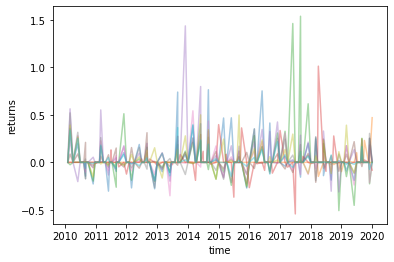

In [151]:
plt.plot(ret, alpha=.4);  
plt.xlabel('time')  
plt.ylabel('returns') 

In [152]:
n = len(tickers)
def rand_weights(n):  
        ''' Produces n random weights that sum to 1 '''  
        k = np.random.rand(n)  
        return k / sum(k)

In [178]:
n_portfolios = 1000

In [179]:
we = []
for i in range(n_portfolios):
    we.append(np.asmatrix(rand_weights(ret.T.shape[0])))

In [184]:
def random_portfolio(returns, we):  
    '''  
    Returns the mean and standard deviation of returns for a random portfolio  
    '''
    mu = []
    sigma = []
    shar = []
    for w in we:
        riskfree = 0.005
        p = np.asmatrix(np.mean(returns, axis=1))  
        #w = np.asmatrix(rand_weights(returns.shape[0]))  
        C = np.asmatrix(np.cov(returns))  
        mu.append(w * p.T)  
        sigma.append(np.sqrt(w * C * w.T))
        shar.append(w * (p.T/np.sqrt(w * C * w.T)))
        
    # This recursion reduces outliers to keep plots pretty  
#     if sigma > 2:  
#         return random_portfolio(returns)  
    return mu, sigma, shar, w

In [185]:
means, stds, shars, w = random_portfolio(ret.T, we)

In [194]:
means = np.squeeze(means)
stds = np.squeeze(stds)
shars = np.squeeze(shars)

In [195]:
print(np.argmax(shars), max(shars))
print(we[np.argmax(shars)])

207 0.2948426435491745
[[0.01628712 0.19033125 0.0230647  0.04570417 0.14053488 0.14315729
  0.02785989 0.07484064 0.278821   0.05939906]]


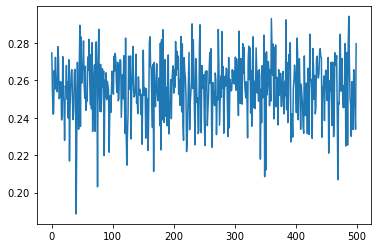

In [196]:
plt.plot(shar)
plt.show()

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

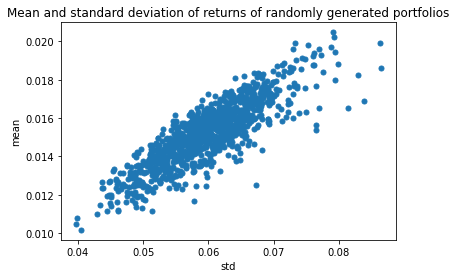

In [197]:
plt.plot(stds, means, 'o', markersize=5)  
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Mean and standard deviation of returns of randomly generated portfolios') 